# Dimensionality Reduction for Mass Spectrometry

This notebook explores various dimensionality reduction techniques for mass spectrometry data:

## Methods Implemented:

### 1. Classical Methods
- **PCA**: Principal Component Analysis (50, 100, 200, 500, 1000 components)
- **UMAP**: Uniform Manifold Approximation and Projection (50, 100, 200 components)

### 2. Tree-based Feature Learning
- **Random Forest Leaf Encoding**: Extract leaf indices as features
- Both with optional PCA post-processing

### 3. Deep Learning Approaches

#### Standard Autoencoder
Unsupervised neural compression learning to reconstruct input features:
- Encoder: $f_\theta: \mathbb{R}^d \rightarrow \mathbb{R}^k$ where $k \ll d$
- Decoder: $g_\phi: \mathbb{R}^k \rightarrow \mathbb{R}^d$
- Objective: $\mathcal{L}_{AE} = \frac{1}{N}\sum_{i=1}^{N} ||x_i - g_\phi(f_\theta(x_i))||_2^2$
- Latent dimensions: 50, 100, 200

#### Contrastive Learning
Dual encoder architecture learning aligned representations of features and targets:
- Feature encoder: $f_\theta: \mathbb{R}^d \rightarrow \mathbb{R}^m \rightarrow \mathbb{R}^p$
- Target encoder: $g_\phi: \mathbb{R}^t \rightarrow \mathbb{R}^m \rightarrow \mathbb{R}^p$
- Projection heads map to shared space $\mathbb{R}^p$ for alignment
- NT-Xent Loss: $\mathcal{L}_{contrast} = -\frac{1}{N}\sum_{i=1}^{N} \log \frac{\exp(sim(z_i^x, z_i^y)/\tau)}{\sum_{j=1}^{N} \exp(sim(z_i^x, z_j^y)/\tau)}$
- Where $sim(u,v) = \frac{u^T v}{||u|| \cdot ||v||}$ and $\tau$ is temperature

#### Supervised Dual Autoencoder
Joint encoding of features and targets with multiple objectives:
- Feature encoder: $f_\theta: \mathbb{R}^d \rightarrow \mathbb{R}^s$ (shared latent space)
- Target encoder: $h_\psi: \mathbb{R}^t \rightarrow \mathbb{R}^s$ (same latent space)
- Feature decoder: $g_\phi: \mathbb{R}^s \rightarrow \mathbb{R}^d$
- Target decoder: $q_\omega: \mathbb{R}^s \rightarrow \mathbb{R}^t$

Multi-objective loss:
$$\mathcal{L}_{DualAE} = \alpha_1 \underbrace{||x - g_\phi(f_\theta(x))||_2^2}_{\text{feature reconstruction}} + \alpha_2 \underbrace{||y - q_\omega(h_\psi(y))||_2^2}_{\text{target reconstruction}}$$
$$+ \alpha_3 \underbrace{||y - q_\omega(f_\theta(x))||_2^2}_{\text{cross-prediction}} + \alpha_4 \underbrace{(1 - \cos(y, q_\omega(f_\theta(x))))}_{\text{cosine similarity}}$$
$$+ \alpha_5 \underbrace{||f_\theta(x) - h_\psi(y)||_2^2}_{\text{latent alignment}}$$

Key difference: The dual AE learns $f_\theta$ such that $f_\theta(x)$ can directly predict $y$, making the latent space task-specific.

### 4. Hybrid Approaches
- **RF Leaves + UMAP**: Combining tree-based features with manifold learning
- **Contrastive + PCA**: Classical reduction on learned representations
- **PCA + Autoencoder**: Concatenating classical and deep features
- **Dual AE + PCA**: Combining supervised embeddings with classical features

## Evaluation Framework:
- All methods are evaluated using a fixed Random Forest configuration
- Primary metric: Cosine similarity between predicted and actual mass spectra
- Compression ratios and training times are tracked
- Train/validation/test splits are preserved for all reduced representations

## 1. Environment Setup

In [1]:
# Standard library imports
import os
import json
import pickle
import warnings
from datetime import datetime
from typing import Dict, List, Tuple, Any, Optional
import time

# Data science imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from scipy.spatial.distance import cosine
from scipy.stats import gaussian_kde

# Machine learning imports
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Deep learning imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# UMAP for dimensionality reduction
import umap

# Configure warnings
warnings.filterwarnings('ignore')

# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else
                      "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

# Set random seeds
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

# Plotting style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("Environment setup complete")

Using device: mps
Environment setup complete


## 2. Master Configuration

In [ ]:
MASTER_CONFIG = {
    # Data paths
    'paths': {
        'results_dir': '../data/results',
        'models_dir': '../models',
        'reduced_dir': '../data/results/reduced_features',
        'input_type': 'hpj',
        'data_subdir': 'full_featurised'
    },
    
    # Classical reduction methods
    'pca': {
        'n_components': [50, 100, 200, 500, 1000]
    },
    'umap': {
        'n_components': [50, 100, 200],
        'n_neighbors': 15,
        'min_dist': 0.1
    },
    
    # Tree-based feature learning
    'tree_leaves': {
        'n_estimators': 100,
        'max_depth': 15,
        'min_samples_leaf': 5,
        'use_pca': True,
        'pca_components': [100, 200, 500]
    },
    
    # Autoencoder settings
    'autoencoder': {
        'architectures': [
            {'name': 'ae_200', 'encoder': [4096, 2048, 1024, 512, 200], 'latent': 200},
            {'name': 'ae_100', 'encoder': [4096, 2048, 1024, 512, 100], 'latent': 100},
            {'name': 'ae_50', 'encoder': [4096, 2048, 512, 50], 'latent': 50}
        ],
        'batch_size': 128,
        'epochs': 50,
        'lr': 1e-3
    },
    
    # Contrastive learning
    'contrastive': {
        'latent_dims': [128, 256],
        'batch_size': 256,
        'contrastive_epochs': 30,
        'regression_epochs': 50,
        'lr_contrastive': 1e-3,
        'lr_regression': 1e-4,
        'temperature': 0.1
    },
    
    # Dual AE
    'dual_ae': {
        'shared_dims': [64, 128, 256],
        'hidden_dims': [2048, 1024, 512],
        'batch_size': 128,
        'epochs': 60,
        'lr': 1e-3,
        'patience': 15,
        'alpha_recon': 2.0,
        'alpha_align': 1.0,
        'alpha_pred': 3.0,
        'alpha_cosine': 2.0
    },
    
    # Random Forest hyperparameters (FIXED for all evaluations)
    'rf': {
        'n_estimators': 100,
        'max_depth': 25,
        'min_samples_split': 3,
        'min_samples_leaf': 1,
        'n_jobs': -1,
        'random_state': 42
    },
    
    # General settings
    'general': {
        'random_state': 42,
        'test_size': 0.2,
        'val_size': 0.1,
        'transform_sqrt': True
    }
}

# Create directories
os.makedirs(MASTER_CONFIG['paths']['reduced_dir'], exist_ok=True)
print(f"Configuration loaded. Reduced features will be saved to: {MASTER_CONFIG['paths']['reduced_dir']}")

Configuration loaded. Reduced features will be saved to: ../reduced_features


## 3. Data Loading and Baseline

In [3]:
def load_jsonl_data(filepath):
    """Load data from JSONL file."""
    smiles_list, features, targets = [], [], []
    
    if not os.path.exists(filepath):
        print(f"File not found: {filepath}")
        return smiles_list, np.array(features), np.array(targets)
    
    with open(filepath, 'r') as f:
        for line in tqdm(f, desc=f"Loading {os.path.basename(filepath)}"):
            try:
                record = json.loads(line)
                if record.get("features") is not None and record.get("target") is not None:
                    smiles_list.append(record.get("smiles", ""))
                    features.append(record["features"])
                    targets.append(record["target"])
            except:
                continue
    
    return smiles_list, np.array(features, dtype=np.float32), np.array(targets, dtype=np.float32)

def save_reduced_features_jsonl(X_train, X_val, X_test, train_smiles, val_smiles, test_smiles, 
                               y_train, y_val, y_test, method_name, save_dir):
    """Save reduced features to JSONL files."""
    os.makedirs(save_dir, exist_ok=True)
    
    # Save train data
    train_path = os.path.join(save_dir, f'{method_name}_train.jsonl')
    with open(train_path, 'w') as f:
        for i in range(len(X_train)):
            record = {
                'smiles': train_smiles[i] if i < len(train_smiles) else '',
                'features': X_train[i].tolist(),
                'target': y_train[i].tolist() if len(y_train[i].shape) > 0 else [y_train[i]]
            }
            f.write(json.dumps(record) + '\n')
    
    # Save val data
    val_path = os.path.join(save_dir, f'{method_name}_val.jsonl')
    with open(val_path, 'w') as f:
        for i in range(len(X_val)):
            record = {
                'smiles': val_smiles[i] if i < len(val_smiles) else '',
                'features': X_val[i].tolist(),
                'target': y_val[i].tolist() if len(y_val[i].shape) > 0 else [y_val[i]]
            }
            f.write(json.dumps(record) + '\n')
    
    # Save test data
    test_path = os.path.join(save_dir, f'{method_name}_test.jsonl')
    with open(test_path, 'w') as f:
        for i in range(len(X_test)):
            record = {
                'smiles': test_smiles[i] if i < len(test_smiles) else '',
                'features': X_test[i].tolist(),
                'target': y_test[i].tolist() if len(y_test[i].shape) > 0 else [y_test[i]]
            }
            f.write(json.dumps(record) + '\n')
    
    print(f"  Saved JSONL files: {method_name}_{{train,val,test}}.jsonl")

def cosine_similarity_score(y_true, y_pred):
    """Calculate mean cosine similarity."""
    similarities = []
    for i in range(len(y_true)):
        if np.sum(y_true[i]) == 0 or np.sum(y_pred[i]) == 0:
            sim = 1.0 if np.sum(y_true[i]) == np.sum(y_pred[i]) else 0.0
        else:
            sim = 1 - cosine(y_true[i], y_pred[i])
        similarities.append(sim)
    return np.mean(similarities)

def evaluate_rf_model(X_train, y_train, X_test, y_test, config, method_name="Method"):
    """Train and evaluate RF model."""
    start_time = time.time()
    
    # Transform targets if needed
    if config['general']['transform_sqrt']:
        y_train = np.sqrt(y_train)
        y_test = np.sqrt(y_test)
    
    # Train RF with fixed hyperparameters
    rf = RandomForestRegressor(**config['rf'])
    rf.fit(X_train, y_train)
    
    # Predict
    y_pred = np.maximum(rf.predict(X_test), 0)
    
    # Calculate metrics
    cosine_sim = cosine_similarity_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    
    train_time = time.time() - start_time
    
    return {
        'method': method_name,
        'n_features': X_train.shape[1],
        'cosine_similarity': cosine_sim,
        'mse': mse,
        'train_time': train_time
    }

def print_compression_summary(original_dim, reduced_dim, method_name):
    """Print verbose compression ratio information."""
    compression_ratio = reduced_dim / original_dim
    reduction_pct = (1 - compression_ratio) * 100
    
    print(f"\n{method_name} Compression Summary:")
    print(f"  Original dimensions: {original_dim:,}")
    print(f"  Reduced dimensions: {reduced_dim:,}")
    print(f"  Compression ratio: {compression_ratio:.4f} ({reduction_pct:.1f}% reduction)")
    print(f"  Data size reduction: {original_dim/reduced_dim:.1f}x smaller")

# Load data
print("Loading datasets...")
data_dir = os.path.join(MASTER_CONFIG['paths']['results_dir'], 
                        MASTER_CONFIG['paths']['input_type'],
                        MASTER_CONFIG['paths']['data_subdir'])

train_smiles, X_train, y_train = load_jsonl_data(os.path.join(data_dir, 'train_data.jsonl'))
val_smiles, X_val, y_val = load_jsonl_data(os.path.join(data_dir, 'val_data.jsonl'))
test_smiles, X_test, y_test = load_jsonl_data(os.path.join(data_dir, 'test_data.jsonl'))

# Store original dimensions
ORIGINAL_DIM = X_train.shape[1]

print(f"\nData loaded:")
print(f"  Train: {X_train.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")
print(f"\nFeature sparsity: {np.mean(X_train == 0)*100:.1f}%")
print(f"Target sparsity: {np.mean(y_train == 0)*100:.1f}%")

# Baseline evaluation
print("\nEvaluating baseline RF on full features...")
results = []
baseline_result = evaluate_rf_model(X_train, y_train, X_test, y_test, 
                                   MASTER_CONFIG, "Baseline (Full Features)")
results.append(baseline_result)
print(f"Baseline Cosine Similarity: {baseline_result['cosine_similarity']:.4f}")
print_compression_summary(ORIGINAL_DIM, ORIGINAL_DIM, "Baseline")

Loading datasets...


Loading train_data.jsonl: 2176it [00:01, 2165.65it/s]
Loading val_data.jsonl: 272it [00:00, 2522.86it/s]
Loading test_data.jsonl: 272it [00:00, 2429.50it/s]



Data loaded:
  Train: (2176, 7135)
  Val: (272, 7135)
  Test: (272, 7135)

Feature sparsity: 77.0%
Target sparsity: 74.5%

Evaluating baseline RF on full features...
Baseline Cosine Similarity: 0.7801

Baseline Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 7,135
  Compression ratio: 1.0000 (0.0% reduction)
  Data size reduction: 1.0x smaller


## 4. Classical Methods (PCA, UMAP)


PCA DIMENSIONALITY REDUCTION

PCA with 50 components...
  Saved JSONL files: pca_50_{train,val,test}.jsonl
  Cosine Similarity: 0.7351
  Explained Variance: 54.7%

PCA-50 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 50
  Compression ratio: 0.0070 (99.3% reduction)
  Data size reduction: 142.7x smaller

PCA with 100 components...
  Saved JSONL files: pca_100_{train,val,test}.jsonl
  Cosine Similarity: 0.7364
  Explained Variance: 65.7%

PCA-100 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 100
  Compression ratio: 0.0140 (98.6% reduction)
  Data size reduction: 71.3x smaller

PCA with 200 components...
  Saved JSONL files: pca_200_{train,val,test}.jsonl
  Cosine Similarity: 0.7340
  Explained Variance: 77.3%

PCA-200 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 200
  Compression ratio: 0.0280 (97.2% reduction)
  Data size reduction: 35.7x smaller

PCA with 500 components...
  Saved JSONL files: pca_500_{tra

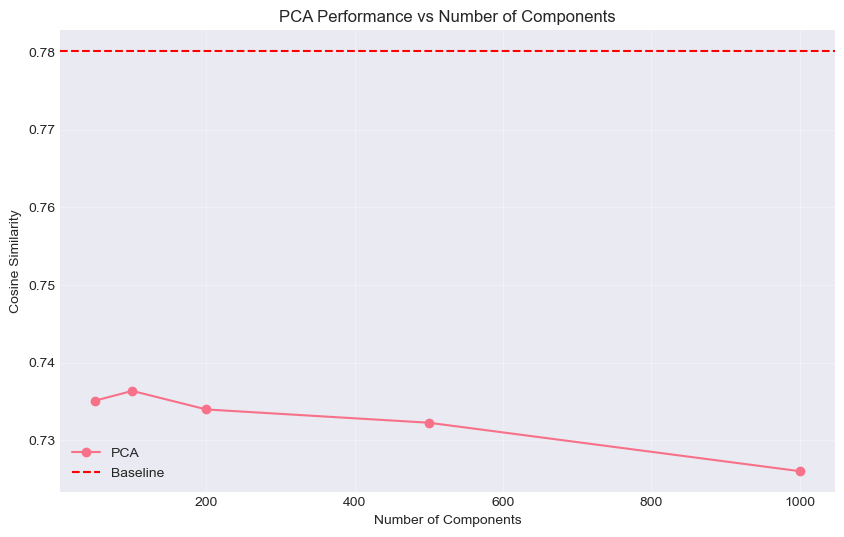

In [4]:
print("\nPCA DIMENSIONALITY REDUCTION")
print("=" * 60)

# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

pca_results = {}

for n_comp in MASTER_CONFIG['pca']['n_components']:
    print(f"\nPCA with {n_comp} components...")
    
    # Fit PCA
    pca = PCA(n_components=n_comp, random_state=SEED)
    X_train_pca = pca.fit_transform(X_train_scaled)
    X_val_pca = pca.transform(X_val_scaled)
    X_test_pca = pca.transform(X_test_scaled)
    
    # Evaluate
    result = evaluate_rf_model(X_train_pca, y_train, X_test_pca, y_test, 
                              MASTER_CONFIG, f"PCA-{n_comp}")
    results.append(result)
    
    # Save reduced features with train/val/test splits
    pca_data = {
        'method': 'pca',
        'n_components': n_comp,
        'pca_model': pca,
        'scaler': scaler,
        'X_train': X_train_pca,
        'X_val': X_val_pca,
        'X_test': X_test_pca,
        'explained_variance_ratio': pca.explained_variance_ratio_,
        'performance': result
    }
    
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], f'pca_{n_comp}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(pca_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_pca, X_val_pca, X_test_pca,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               f'pca_{n_comp}', MASTER_CONFIG['paths']['reduced_dir'])
    
    pca_results[n_comp] = result
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    print(f"  Explained Variance: {np.sum(pca.explained_variance_ratio_)*100:.1f}%")
    
    # Print compression summary
    print_compression_summary(ORIGINAL_DIM, n_comp, f"PCA-{n_comp}")

# Visualize PCA results
plt.figure(figsize=(10, 6))
n_components = [r['n_features'] for r in results if 'PCA' in r['method']]
cosine_sims = [r['cosine_similarity'] for r in results if 'PCA' in r['method']]
plt.plot(n_components, cosine_sims, 'o-', label='PCA')
plt.axhline(y=baseline_result['cosine_similarity'], color='r', linestyle='--', label='Baseline')
plt.xlabel('Number of Components')
plt.ylabel('Cosine Similarity')
plt.title('PCA Performance vs Number of Components')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


UMAP DIMENSIONALITY REDUCTION

UMAP with 50 components...
  Saved JSONL files: umap_50_{train,val,test}.jsonl
  Cosine Similarity: 0.6649

UMAP-50 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 50
  Compression ratio: 0.0070 (99.3% reduction)
  Data size reduction: 142.7x smaller

UMAP with 100 components...
  Saved JSONL files: umap_100_{train,val,test}.jsonl
  Cosine Similarity: 0.6638

UMAP-100 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 100
  Compression ratio: 0.0140 (98.6% reduction)
  Data size reduction: 71.3x smaller

UMAP with 200 components...
  Saved JSONL files: umap_200_{train,val,test}.jsonl
  Cosine Similarity: 0.6678

UMAP-200 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 200
  Compression ratio: 0.0280 (97.2% reduction)
  Data size reduction: 35.7x smaller

Creating 2D UMAP visualization...


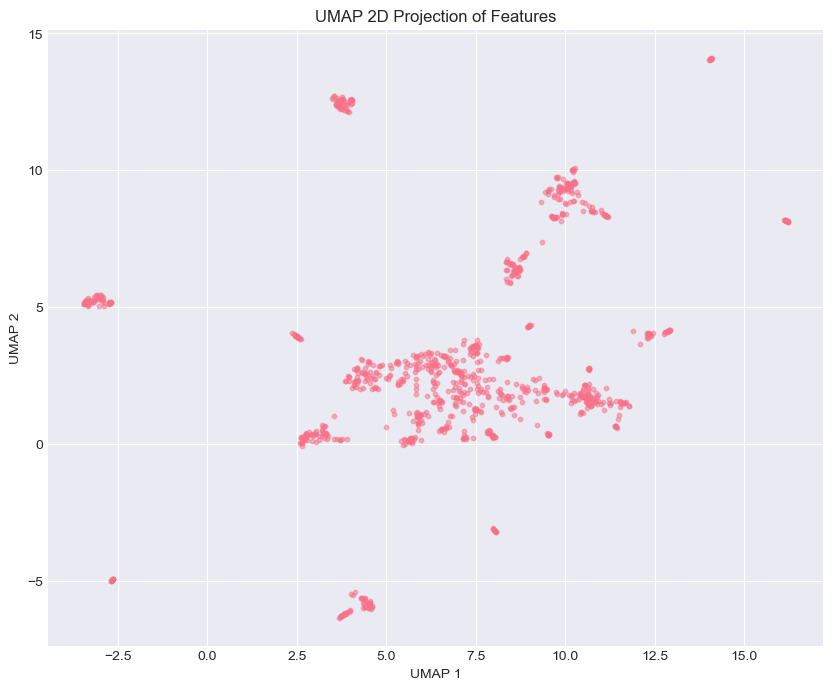

In [5]:
print("\nUMAP DIMENSIONALITY REDUCTION")
print("=" * 60)

umap_results = {}

for n_comp in MASTER_CONFIG['umap']['n_components']:
    print(f"\nUMAP with {n_comp} components...")
    
    # Fit UMAP
    reducer = umap.UMAP(
        n_components=n_comp,
        n_neighbors=MASTER_CONFIG['umap']['n_neighbors'],
        min_dist=MASTER_CONFIG['umap']['min_dist'],
        random_state=SEED
    )
    
    X_train_umap = reducer.fit_transform(X_train_scaled)
    X_val_umap = reducer.transform(X_val_scaled)
    X_test_umap = reducer.transform(X_test_scaled)
    
    # Evaluate
    result = evaluate_rf_model(X_train_umap, y_train, X_test_umap, y_test, 
                              MASTER_CONFIG, f"UMAP-{n_comp}")
    results.append(result)
    
    # Save reduced features with train/val/test splits
    umap_data = {
        'method': 'umap',
        'n_components': n_comp,
        'umap_model': reducer,
        'scaler': scaler,
        'X_train': X_train_umap,
        'X_val': X_val_umap,
        'X_test': X_test_umap,
        'performance': result
    }
    
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], f'umap_{n_comp}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(umap_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_umap, X_val_umap, X_test_umap,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               f'umap_{n_comp}', MASTER_CONFIG['paths']['reduced_dir'])
    
    umap_results[n_comp] = result
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    
    # Print compression summary
    print_compression_summary(ORIGINAL_DIM, n_comp, f"UMAP-{n_comp}")

# Visualize 2D UMAP for interpretation
print("\nCreating 2D UMAP visualization...")
umap_2d = umap.UMAP(n_components=2, random_state=SEED)
X_vis = umap_2d.fit_transform(X_train_scaled[:1000])  # Subset for speed

plt.figure(figsize=(10, 8))
plt.scatter(X_vis[:, 0], X_vis[:, 1], alpha=0.5, s=10)
plt.title('UMAP 2D Projection of Features')
plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.show()

## 5. Tree-based Feature Learning (RF Leaf Encoding)

In [6]:
print("\nTREE-BASED FEATURE LEARNING")
print("=" * 60)

def get_leaf_encoding(model, X, model_type='rf'):
    """Extract leaf indices from tree model."""
    if model_type == 'rf':
        # For Random Forest
        n_trees = len(model.estimators_)
        leaf_indices = np.zeros((X.shape[0], n_trees), dtype=np.int32)
        
        for tree_idx, tree in enumerate(model.estimators_):
            leaf_indices[:, tree_idx] = tree.apply(X)
    
    return leaf_indices

def one_hot_encode_leaves(leaf_indices, n_trees, max_leaves_per_tree):
    """One-hot encode leaf indices."""
    n_samples = leaf_indices.shape[0]
    n_features = n_trees * max_leaves_per_tree
    
    # Create sparse one-hot encoding
    one_hot = np.zeros((n_samples, n_features), dtype=np.float32)
    
    for tree_idx in range(n_trees):
        tree_offset = tree_idx * max_leaves_per_tree
        leaf_positions = leaf_indices[:, tree_idx] + tree_offset
        one_hot[np.arange(n_samples), leaf_positions] = 1
    
    return one_hot

# Train RF for leaf encoding
print("\nTraining Random Forest for leaf encoding...")
rf_encoder = RandomForestRegressor(
    n_estimators=MASTER_CONFIG['tree_leaves']['n_estimators'],
    max_depth=MASTER_CONFIG['tree_leaves']['max_depth'],
    min_samples_leaf=MASTER_CONFIG['tree_leaves']['min_samples_leaf'],
    random_state=SEED,
    n_jobs=-1
)

# Train on sqrt-transformed targets
y_train_sqrt = np.sqrt(y_train) if MASTER_CONFIG['general']['transform_sqrt'] else y_train
rf_encoder.fit(X_train, y_train_sqrt)

# Extract leaf encodings
print("Extracting leaf encodings...")
train_leaves = get_leaf_encoding(rf_encoder, X_train, 'rf')
val_leaves = get_leaf_encoding(rf_encoder, X_val, 'rf')
test_leaves = get_leaf_encoding(rf_encoder, X_test, 'rf')

# Get max leaf index per tree
max_leaves = train_leaves.max() + 1

# One-hot encode
print("One-hot encoding leaf indices...")
X_train_leaves_oh = one_hot_encode_leaves(train_leaves, 
                                          MASTER_CONFIG['tree_leaves']['n_estimators'], 
                                          max_leaves)
X_val_leaves_oh = one_hot_encode_leaves(val_leaves, 
                                        MASTER_CONFIG['tree_leaves']['n_estimators'], 
                                        max_leaves)
X_test_leaves_oh = one_hot_encode_leaves(test_leaves, 
                                         MASTER_CONFIG['tree_leaves']['n_estimators'], 
                                         max_leaves)

print(f"Leaf encoding shape: {X_train_leaves_oh.shape}")
print(f"Sparsity: {np.mean(X_train_leaves_oh == 0)*100:.1f}%")

# Evaluate raw leaf encoding
result = evaluate_rf_model(X_train_leaves_oh, y_train, X_test_leaves_oh, y_test, 
                          MASTER_CONFIG, "RF-Leaves-Raw")
results.append(result)
print(f"\nRF Leaf Encoding (Raw) - Cosine Similarity: {result['cosine_similarity']:.4f}")
print_compression_summary(ORIGINAL_DIM, X_train_leaves_oh.shape[1], "RF-Leaves-Raw")

# Apply PCA to leaf encodings
if MASTER_CONFIG['tree_leaves']['use_pca']:
    for n_comp in MASTER_CONFIG['tree_leaves']['pca_components']:
        if n_comp < X_train_leaves_oh.shape[1]:
            print(f"\nApplying PCA with {n_comp} components to leaf encodings...")
            
            pca_leaves = PCA(n_components=n_comp, random_state=SEED)
            X_train_leaves_pca = pca_leaves.fit_transform(X_train_leaves_oh)
            X_val_leaves_pca = pca_leaves.transform(X_val_leaves_oh)
            X_test_leaves_pca = pca_leaves.transform(X_test_leaves_oh)
            
            # Evaluate
            result = evaluate_rf_model(X_train_leaves_pca, y_train, X_test_leaves_pca, y_test, 
                                      MASTER_CONFIG, f"RF-Leaves-PCA{n_comp}")
            results.append(result)
            
            # Save with train/val/test splits
            leaf_data = {
                'method': 'rf_leaves_pca',
                'n_components': n_comp,
                'rf_encoder': rf_encoder,
                'pca_model': pca_leaves,
                'max_leaves': max_leaves,
                'X_train': X_train_leaves_pca,
                'X_val': X_val_leaves_pca,
                'X_test': X_test_leaves_pca,
                'performance': result
            }
            
            save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], f'rf_leaves_pca_{n_comp}.pkl')
            with open(save_path, 'wb') as f:
                pickle.dump(leaf_data, f)
            
            # Save JSONL files
            save_reduced_features_jsonl(X_train_leaves_pca, X_val_leaves_pca, X_test_leaves_pca,
                                       train_smiles, val_smiles, test_smiles,
                                       y_train, y_val, y_test,
                                       f'rf_leaves_pca_{n_comp}', MASTER_CONFIG['paths']['reduced_dir'])
            
            print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
            print_compression_summary(ORIGINAL_DIM, n_comp, f"RF-Leaves-PCA{n_comp}")


TREE-BASED FEATURE LEARNING

Training Random Forest for leaf encoding...
Extracting leaf encodings...
One-hot encoding leaf indices...
Leaf encoding shape: (2176, 45100)
Sparsity: 99.8%

RF Leaf Encoding (Raw) - Cosine Similarity: 0.6224

RF-Leaves-Raw Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 45,100
  Compression ratio: 6.3210 (-532.1% reduction)
  Data size reduction: 0.2x smaller

Applying PCA with 100 components to leaf encodings...
  Saved JSONL files: rf_leaves_pca_100_{train,val,test}.jsonl
  Cosine Similarity: 0.7519

RF-Leaves-PCA100 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 100
  Compression ratio: 0.0140 (98.6% reduction)
  Data size reduction: 71.3x smaller

Applying PCA with 200 components to leaf encodings...
  Saved JSONL files: rf_leaves_pca_200_{train,val,test}.jsonl
  Cosine Similarity: 0.7567

RF-Leaves-PCA200 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 200
  Compression ratio: 0

## 6. Deep Autoencoder

In [7]:
print("\nDEEP AUTOENCODER")
print("=" * 60)

class Autoencoder(nn.Module):
    def __init__(self, input_dim, encoder_dims, latent_dim):
        super().__init__()
        
        # Encoder
        encoder_layers = []
        prev_dim = input_dim
        for dim in encoder_dims:
            encoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        
        encoder_layers.append(nn.Linear(prev_dim, latent_dim))
        self.encoder = nn.Sequential(*encoder_layers)
        
        # Decoder (mirror of encoder)
        decoder_dims = encoder_dims[::-1]
        decoder_layers = [nn.Linear(latent_dim, decoder_dims[0]), nn.ReLU()]
        
        prev_dim = decoder_dims[0]
        for dim in decoder_dims[1:]:
            decoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        
        decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.decoder = nn.Sequential(*decoder_layers)
        
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        z = self.encode(x)
        return self.decode(z)

def train_autoencoder(model, train_loader, val_loader, epochs, lr):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5)
    
    train_losses = []
    val_losses = []
    
    for epoch in range(epochs):
        # Training
        model.train()
        train_loss = 0
        for batch in train_loader:
            x = batch[0].to(device)
            
            optimizer.zero_grad()
            x_recon = model(x)
            loss = F.mse_loss(x_recon, x)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch in val_loader:
                x = batch[0].to(device)
                x_recon = model(x)
                loss = F.mse_loss(x_recon, x)
                val_loss += loss.item()
        
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        
        scheduler.step(avg_val_loss)
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}/{epochs}: Train Loss={avg_train_loss:.4f}, Val Loss={avg_val_loss:.4f}")
    
    return train_losses, val_losses

# Create data loaders
train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled))

train_loader = DataLoader(train_dataset, 
                         batch_size=MASTER_CONFIG['autoencoder']['batch_size'], 
                         shuffle=True)
val_loader = DataLoader(val_dataset, 
                       batch_size=MASTER_CONFIG['autoencoder']['batch_size'])

# Train different architectures
for arch in MASTER_CONFIG['autoencoder']['architectures']:
    print(f"\nTraining {arch['name']}...")
    
    model = Autoencoder(
        input_dim=X_train.shape[1],
        encoder_dims=arch['encoder'][:-1],  # Remove latent dim from list
        latent_dim=arch['latent']
    ).to(device)
    
    train_losses, val_losses = train_autoencoder(
        model, train_loader, val_loader,
        epochs=MASTER_CONFIG['autoencoder']['epochs'],
        lr=MASTER_CONFIG['autoencoder']['lr']
    )
    
    # Extract embeddings
    model.eval()
    with torch.no_grad():
        X_train_ae = model.encode(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
        X_val_ae = model.encode(torch.FloatTensor(X_val_scaled).to(device)).cpu().numpy()
        X_test_ae = model.encode(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
    
    # Evaluate
    result = evaluate_rf_model(X_train_ae, y_train, X_test_ae, y_test, 
                              MASTER_CONFIG, arch['name'].upper())
    results.append(result)
    
    # Save with train/val/test splits
    ae_data = {
        'method': 'autoencoder',
        'architecture': arch,
        'model': model.state_dict(),
        'scaler': scaler,
        'X_train': X_train_ae,
        'X_val': X_val_ae,
        'X_test': X_test_ae,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'performance': result
    }
    
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], f"{arch['name']}.pkl")
    with open(save_path, 'wb') as f:
        pickle.dump(ae_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_ae, X_val_ae, X_test_ae,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               arch['name'], MASTER_CONFIG['paths']['reduced_dir'])
    
    print(f"  Final Val Loss: {val_losses[-1]:.4f}")
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    print_compression_summary(ORIGINAL_DIM, arch['latent'], arch['name'].upper())


DEEP AUTOENCODER

Training ae_200...
  Epoch 10/50: Train Loss=0.6046, Val Loss=0.5820
  Epoch 20/50: Train Loss=0.4643, Val Loss=0.4896
  Epoch 30/50: Train Loss=0.3677, Val Loss=0.4299
  Epoch 40/50: Train Loss=0.2847, Val Loss=0.3913
  Epoch 50/50: Train Loss=0.2347, Val Loss=0.3804
  Saved JSONL files: ae_200_{train,val,test}.jsonl
  Final Val Loss: 0.3804
  Cosine Similarity: 0.7328

AE_200 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 200
  Compression ratio: 0.0280 (97.2% reduction)
  Data size reduction: 35.7x smaller

Training ae_100...
  Epoch 10/50: Train Loss=0.5970, Val Loss=0.5759
  Epoch 20/50: Train Loss=0.4606, Val Loss=0.4808
  Epoch 30/50: Train Loss=0.3641, Val Loss=0.4418
  Epoch 40/50: Train Loss=0.2846, Val Loss=0.3899
  Epoch 50/50: Train Loss=0.2086, Val Loss=0.3615
  Saved JSONL files: ae_100_{train,val,test}.jsonl
  Final Val Loss: 0.3615
  Cosine Similarity: 0.7306

AE_100 Compression Summary:
  Original dimensions: 7,135
  Reduced

## 7. Contrastive Learning

In [8]:
print("\nCONTRASTIVE LEARNING")
print("=" * 60)

class InputEncoder(nn.Module):
    def __init__(self, input_dim, hidden_dims=[2048, 1024, 512], dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = input_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        self.output_dim = hidden_dims[-1]
        
    def forward(self, x):
        return self.encoder(x)

class OutputEncoder(nn.Module):
    def __init__(self, output_dim, hidden_dims=[256, 512], dropout=0.2):
        super().__init__()
        layers = []
        prev_dim = output_dim
        
        for hidden_dim in hidden_dims:
            layers.extend([
                nn.Linear(prev_dim, hidden_dim),
                nn.LayerNorm(hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout)
            ])
            prev_dim = hidden_dim
        
        self.encoder = nn.Sequential(*layers)
        self.embedding_dim = hidden_dims[-1]
        
    def forward(self, y):
        return self.encoder(y)

class ProjectionHead(nn.Module):
    def __init__(self, input_dim, hidden_dim=256, output_dim=128):
        super().__init__()
        self.projection = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, output_dim)
        )
        
    def forward(self, x):
        return F.normalize(self.projection(x), p=2, dim=1)

class ContrastiveModel(nn.Module):
    def __init__(self, input_dim, output_dim, latent_dim=128):
        super().__init__()
        
        # Encoders
        self.input_encoder = InputEncoder(input_dim)
        self.output_encoder = OutputEncoder(output_dim)
        
        # Projection heads
        self.input_projection = ProjectionHead(
            self.input_encoder.output_dim, output_dim=latent_dim
        )
        self.output_projection = ProjectionHead(
            self.output_encoder.embedding_dim, output_dim=latent_dim
        )
        
    def forward(self, x, y):
        # Encode
        x_emb = self.input_encoder(x)
        y_emb = self.output_encoder(y)
        
        # Project to shared space
        x_proj = self.input_projection(x_emb)
        y_proj = self.output_projection(y_emb)
        
        return x_proj, y_proj, x_emb

class NTXentLoss(nn.Module):
    def __init__(self, temperature=0.1):
        super().__init__()
        self.temperature = temperature
        
    def forward(self, x_proj, y_proj):
        batch_size = x_proj.shape[0]
        
        # Compute similarity matrix
        similarity = torch.matmul(x_proj, y_proj.T) / self.temperature
        
        # Positive pairs are on diagonal
        labels = torch.arange(batch_size, device=x_proj.device)
        
        # Cross entropy loss
        loss = F.cross_entropy(similarity, labels)
        
        return loss

# Create data loaders with targets
train_dataset = TensorDataset(torch.FloatTensor(X_train_scaled), 
                             torch.FloatTensor(y_train))
val_dataset = TensorDataset(torch.FloatTensor(X_val_scaled), 
                           torch.FloatTensor(y_val))

train_loader = DataLoader(train_dataset, 
                         batch_size=MASTER_CONFIG['contrastive']['batch_size'], 
                         shuffle=True)
val_loader = DataLoader(val_dataset, 
                       batch_size=MASTER_CONFIG['contrastive']['batch_size'])

# Train contrastive model
for latent_dim in MASTER_CONFIG['contrastive']['latent_dims']:
    print(f"\nTraining Contrastive Model with latent_dim={latent_dim}...")
    
    contrastive_model = ContrastiveModel(
        input_dim=X_train.shape[1],
        output_dim=y_train.shape[1],
        latent_dim=latent_dim
    ).to(device)
    
    optimizer = optim.AdamW(contrastive_model.parameters(), 
                           lr=MASTER_CONFIG['contrastive']['lr_contrastive'])
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, 
                                                     T_max=MASTER_CONFIG['contrastive']['contrastive_epochs'])
    criterion = NTXentLoss(temperature=MASTER_CONFIG['contrastive']['temperature'])
    
    # Contrastive pretraining
    for epoch in range(MASTER_CONFIG['contrastive']['contrastive_epochs']):
        contrastive_model.train()
        train_loss = 0
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            x_proj, y_proj, _ = contrastive_model(X_batch, y_batch)
            loss = criterion(x_proj, y_proj)
            
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item()
        
        scheduler.step()
        
        if (epoch + 1) % 10 == 0:
            avg_loss = train_loss / len(train_loader)
            print(f"  Epoch {epoch+1}: Contrastive Loss={avg_loss:.4f}")
    
    # Extract learned representations
    contrastive_model.eval()
    with torch.no_grad():
        X_train_cont = contrastive_model.input_encoder(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
        X_val_cont = contrastive_model.input_encoder(torch.FloatTensor(X_val_scaled).to(device)).cpu().numpy()
        X_test_cont = contrastive_model.input_encoder(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
    
    # Evaluate
    result = evaluate_rf_model(X_train_cont, y_train, X_test_cont, y_test, 
                              MASTER_CONFIG, f"Contrastive-{latent_dim}")
    results.append(result)
    
    # Save with train/val/test splits
    contrastive_data = {
        'method': 'contrastive',
        'latent_dim': latent_dim,
        'model': contrastive_model.state_dict(),
        'scaler': scaler,
        'X_train': X_train_cont,
        'X_val': X_val_cont,
        'X_test': X_test_cont,
        'performance': result
    }
    
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], f'contrastive_{latent_dim}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(contrastive_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_cont, X_val_cont, X_test_cont,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               f'contrastive_{latent_dim}', MASTER_CONFIG['paths']['reduced_dir'])
    
    print(f"  Embedding dim: {X_train_cont.shape[1]}")
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    print_compression_summary(ORIGINAL_DIM, X_train_cont.shape[1], f"Contrastive-{latent_dim}")


CONTRASTIVE LEARNING

Training Contrastive Model with latent_dim=128...
  Epoch 10: Contrastive Loss=2.0349
  Epoch 20: Contrastive Loss=1.3315
  Epoch 30: Contrastive Loss=1.1784
  Saved JSONL files: contrastive_128_{train,val,test}.jsonl
  Embedding dim: 512
  Cosine Similarity: 0.7475

Contrastive-128 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 512
  Compression ratio: 0.0718 (92.8% reduction)
  Data size reduction: 13.9x smaller

Training Contrastive Model with latent_dim=256...
  Epoch 10: Contrastive Loss=2.0479
  Epoch 20: Contrastive Loss=1.3429
  Epoch 30: Contrastive Loss=1.1640
  Saved JSONL files: contrastive_256_{train,val,test}.jsonl
  Embedding dim: 512
  Cosine Similarity: 0.7542

Contrastive-256 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 512
  Compression ratio: 0.0718 (92.8% reduction)
  Data size reduction: 13.9x smaller


## 8. Supervised Dual Autoencoder

In [9]:
print("\nSUPERVISED DUAL AUTOENCODER")
print("=" * 60)

class DualAutoencoder(nn.Module):
    def __init__(self, input_dim, target_dim, shared_dim=256, hidden_dims=[2048, 1024, 512]):
        super().__init__()
        
        # Feature encoder
        feat_encoder_layers = []
        prev_dim = input_dim
        for dim in hidden_dims:
            feat_encoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        feat_encoder_layers.append(nn.Linear(prev_dim, shared_dim))
        self.feature_encoder = nn.Sequential(*feat_encoder_layers)
        
        # Target encoder
        target_encoder_layers = []
        prev_dim = target_dim
        for dim in [512, 512]:
            target_encoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        target_encoder_layers.append(nn.Linear(prev_dim, shared_dim))
        self.target_encoder = nn.Sequential(*target_encoder_layers)
        
        # Projection heads for better alignment
        self.feature_projector = nn.Sequential(
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, shared_dim)
        )
        self.target_projector = nn.Sequential(
            nn.Linear(shared_dim, shared_dim),
            nn.ReLU(),
            nn.Linear(shared_dim, shared_dim)
        )
        
        # Feature decoder
        feat_decoder_layers = []
        decoder_dims = hidden_dims[::-1]
        prev_dim = shared_dim
        for dim in decoder_dims:
            feat_decoder_layers.extend([
                nn.Linear(prev_dim, dim),
                nn.ReLU(),
                nn.BatchNorm1d(dim),
                nn.Dropout(0.2)
            ])
            prev_dim = dim
        feat_decoder_layers.append(nn.Linear(prev_dim, input_dim))
        self.feature_decoder = nn.Sequential(*feat_decoder_layers)
        
        # Target decoder
        target_decoder_layers = [
            nn.Linear(shared_dim, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, 1024),
            nn.ReLU(),
            nn.BatchNorm1d(1024),
            nn.Dropout(0.2),
            nn.Linear(1024, target_dim),
            nn.ReLU()  # Ensure non-negative
        ]
        self.target_decoder = nn.Sequential(*target_decoder_layers)
        
        self.shared_dim = shared_dim
        
    def encode_features(self, x):
        return self.feature_encoder(x)
    
    def encode_targets(self, y):
        return self.target_encoder(y)
    
    def decode_features(self, z):
        return self.feature_decoder(z)
    
    def decode_targets(self, z):
        return self.target_decoder(z)
    
    def forward(self, x, y):
        # Encode both
        z_x = self.encode_features(x)
        z_y = self.encode_targets(y)
        
        # Project for alignment
        z_x_proj = self.feature_projector(z_x)
        z_y_proj = self.target_projector(z_y)
        
        # Decode both
        x_recon = self.decode_features(z_x)
        y_recon = self.decode_targets(z_x)  # Key: predict targets from features
        
        # Also decode from target embedding
        x_from_y = self.decode_features(z_y)
        y_from_y = self.decode_targets(z_y)
        
        return z_x, z_y, z_x_proj, z_y_proj, x_recon, y_recon, x_from_y, y_from_y

def cosine_loss(pred, target, eps=1e-8):
    """Cosine distance loss for better spectrum matching."""
    pred_norm = pred / (torch.norm(pred, dim=1, keepdim=True) + eps)
    target_norm = target / (torch.norm(target, dim=1, keepdim=True) + eps)
    return 1 - (pred_norm * target_norm).sum(dim=1).mean()

def dual_autoencoder_loss(z_x, z_y, z_x_proj, z_y_proj, x, y, x_recon, y_recon, x_from_y, y_from_y, 
                         alpha_recon=2.0, alpha_align=1.0, alpha_pred=3.0, alpha_cosine=2.0):
    """Enhanced loss with cosine similarity for spectra."""
    # Reconstruction losses
    loss_x_recon = F.mse_loss(x_recon, x)
    loss_y_recon = F.mse_loss(y_from_y, y)
    
    # Cross-prediction losses
    loss_y_pred_mse = F.mse_loss(y_recon, y)
    loss_y_pred_cosine = cosine_loss(y_recon, y)
    loss_x_pred = F.mse_loss(x_from_y, x)
    
    # Alignment loss in projection space
    loss_align = F.mse_loss(z_x_proj, z_y_proj)
    
    # Contrastive alignment
    z_x_norm = F.normalize(z_x_proj, p=2, dim=1)
    z_y_norm = F.normalize(z_y_proj, p=2, dim=1)
    loss_contrastive = 1 - (z_x_norm * z_y_norm).sum(dim=1).mean()
    
    total_loss = (alpha_recon * (loss_x_recon + loss_y_recon) +
                  alpha_align * (loss_align + loss_contrastive) +
                  alpha_pred * loss_y_pred_mse +
                  alpha_cosine * loss_y_pred_cosine +
                  0.5 * loss_x_pred)
    
    return total_loss, {
        'x_recon': loss_x_recon.item(),
        'y_recon': loss_y_recon.item(),
        'y_pred_mse': loss_y_pred_mse.item(),
        'y_pred_cosine': loss_y_pred_cosine.item(),
        'align': loss_align.item(),
        'contrastive': loss_contrastive.item()
    }

# Train different embedding dimensions
for shared_dim in MASTER_CONFIG['dual_ae']['shared_dims']:
    print(f"\nTraining Dual Autoencoder with {shared_dim}D embeddings...")
    
    model = DualAutoencoder(
        input_dim=X_train.shape[1],
        target_dim=y_train.shape[1],
        shared_dim=shared_dim,
        hidden_dims=MASTER_CONFIG['dual_ae']['hidden_dims']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=MASTER_CONFIG['dual_ae']['lr'])
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)
    
    # Create data loaders
    y_train_sqrt = np.sqrt(y_train) if MASTER_CONFIG['general']['transform_sqrt'] else y_train
    y_val_sqrt = np.sqrt(y_val) if MASTER_CONFIG['general']['transform_sqrt'] else y_val
    
    train_dataset = TensorDataset(
        torch.FloatTensor(X_train_scaled), 
        torch.FloatTensor(y_train_sqrt)
    )
    val_dataset = TensorDataset(
        torch.FloatTensor(X_val_scaled),
        torch.FloatTensor(y_val_sqrt)
    )
    
    train_loader = DataLoader(train_dataset, 
                             batch_size=MASTER_CONFIG['dual_ae']['batch_size'], 
                             shuffle=True)
    val_loader = DataLoader(val_dataset, 
                           batch_size=MASTER_CONFIG['dual_ae']['batch_size'])
    
    # Training loop with early stopping
    best_val_cosine = 0
    patience_counter = 0
    
    for epoch in range(MASTER_CONFIG['dual_ae']['epochs']):
        # Training
        model.train()
        train_losses = []
        
        for X_batch, y_batch in train_loader:
            X_batch = X_batch.to(device)
            y_batch = y_batch.to(device)
            
            optimizer.zero_grad()
            z_x, z_y, z_x_proj, z_y_proj, x_recon, y_recon, x_from_y, y_from_y = model(X_batch, y_batch)
            loss, loss_components = dual_autoencoder_loss(
                z_x, z_y, z_x_proj, z_y_proj, X_batch, y_batch, 
                x_recon, y_recon, x_from_y, y_from_y,
                alpha_recon=MASTER_CONFIG['dual_ae']['alpha_recon'],
                alpha_align=MASTER_CONFIG['dual_ae']['alpha_align'],
                alpha_pred=MASTER_CONFIG['dual_ae']['alpha_pred'],
                alpha_cosine=MASTER_CONFIG['dual_ae']['alpha_cosine']
            )
            
            loss.backward()
            optimizer.step()
            train_losses.append(loss.item())
        
        # Validation
        model.eval()
        val_losses = []
        val_cosine_sims = []
        
        with torch.no_grad():
            for X_batch, y_batch in val_loader:
                X_batch = X_batch.to(device)
                y_batch = y_batch.to(device)
                
                z_x, z_y, z_x_proj, z_y_proj, x_recon, y_recon, x_from_y, y_from_y = model(X_batch, y_batch)
                loss, _ = dual_autoencoder_loss(
                    z_x, z_y, z_x_proj, z_y_proj, X_batch, y_batch, 
                    x_recon, y_recon, x_from_y, y_from_y,
                    alpha_recon=MASTER_CONFIG['dual_ae']['alpha_recon'],
                    alpha_align=MASTER_CONFIG['dual_ae']['alpha_align'],
                    alpha_pred=MASTER_CONFIG['dual_ae']['alpha_pred'],
                    alpha_cosine=MASTER_CONFIG['dual_ae']['alpha_cosine']
                )
                val_losses.append(loss.item())
                
                # Calculate cosine similarity for predicted targets
                y_pred_np = y_recon.cpu().numpy()
                y_true_np = y_batch.cpu().numpy()
                batch_cosine = cosine_similarity_score(y_true_np, y_pred_np)
                val_cosine_sims.append(batch_cosine)
        
        avg_train_loss = np.mean(train_losses)
        avg_val_loss = np.mean(val_losses)
        avg_val_cosine = np.mean(val_cosine_sims)
        
        scheduler.step(avg_val_loss)
        
        # Early stopping based on validation cosine similarity
        if avg_val_cosine > best_val_cosine:
            best_val_cosine = avg_val_cosine
            best_model_state = model.state_dict()
            patience_counter = 0
        else:
            patience_counter += 1
        
        if (epoch + 1) % 10 == 0:
            print(f"  Epoch {epoch+1}: Train Loss={avg_train_loss:.4f}, "
                  f"Val Loss={avg_val_loss:.4f}, Val Cosine={avg_val_cosine:.4f}")
        
        if patience_counter >= MASTER_CONFIG['dual_ae']['patience']:
            print(f"  Early stopping at epoch {epoch+1} - Best val cosine: {best_val_cosine:.4f}")
            model.load_state_dict(best_model_state)
            break
    
    # Extract feature latents
    print(f"Extracting feature latents...")
    model.eval()
    with torch.no_grad():
        FL_train = model.encode_features(torch.FloatTensor(X_train_scaled).to(device)).cpu().numpy()
        FL_val = model.encode_features(torch.FloatTensor(X_val_scaled).to(device)).cpu().numpy()
        FL_test = model.encode_features(torch.FloatTensor(X_test_scaled).to(device)).cpu().numpy()
    
    # Evaluate FL → S using standard RF evaluation
    result = evaluate_rf_model(FL_train, y_train, FL_test, y_test, 
                              MASTER_CONFIG, f"DualAE-{shared_dim}")
    results.append(result)
    
    print(f"\nDualAE-{shared_dim} Results:")
    print(f"  Feature Latent Dimension: {shared_dim}")
    print(f"  FL→S Cosine Similarity: {result['cosine_similarity']:.4f}")
    print(f"  Training Time: {result['train_time']:.2f}s")
    print_compression_summary(ORIGINAL_DIM, shared_dim, f"DualAE-{shared_dim}")
    
    # Save model and embeddings with train/val/test splits
    dual_ae_data = {
        'method': 'dual_autoencoder',
        'shared_dim': shared_dim,
        'model': best_model_state,
        'model_config': {
            'input_dim': X_train.shape[1],
            'target_dim': y_train.shape[1],
            'shared_dim': shared_dim,
            'hidden_dims': MASTER_CONFIG['dual_ae']['hidden_dims']
        },
        'scaler': scaler,
        'X_train': FL_train,
        'X_val': FL_val,
        'X_test': FL_test,
        'performance': result,
        'best_val_cosine': best_val_cosine
    }
    
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], f'dual_ae_{shared_dim}.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(dual_ae_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(FL_train, FL_val, FL_test,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               f'dual_ae_{shared_dim}', MASTER_CONFIG['paths']['reduced_dir'])
    
    print(f"  Saved to: {save_path}")

print("\nDual Autoencoder training complete!")


SUPERVISED DUAL AUTOENCODER

Training Dual Autoencoder with 64D embeddings...
  Epoch 10: Train Loss=2.1758, Val Loss=2.2194, Val Cosine=0.6827
  Epoch 20: Train Loss=1.7070, Val Loss=1.9049, Val Cosine=0.7083
  Epoch 30: Train Loss=1.3975, Val Loss=1.8059, Val Cosine=0.7100
  Epoch 40: Train Loss=1.1143, Val Loss=1.6472, Val Cosine=0.7397
  Epoch 50: Train Loss=0.9929, Val Loss=1.6413, Val Cosine=0.7277
  Early stopping at epoch 58 - Best val cosine: 0.7432
Extracting feature latents...

DualAE-64 Results:
  Feature Latent Dimension: 64
  FL→S Cosine Similarity: 0.7518
  Training Time: 6.12s

DualAE-64 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 64
  Compression ratio: 0.0090 (99.1% reduction)
  Data size reduction: 111.5x smaller
  Saved JSONL files: dual_ae_64_{train,val,test}.jsonl
  Saved to: ../reduced_features/dual_ae_64.pkl

Training Dual Autoencoder with 128D embeddings...
  Epoch 10: Train Loss=2.2077, Val Loss=2.1759, Val Cosine=0.6955
  Epoch 20

## 9. Hybrid Approaches

In [10]:
print("\nHYBRID APPROACHES")
print("=" * 60)

# Hybrid 1: RF Leaves + UMAP
print("\nHybrid 1: RF Leaves + UMAP...")
umap_hybrid = umap.UMAP(n_components=50, random_state=SEED)
X_train_hybrid1 = umap_hybrid.fit_transform(X_train_leaves_oh)
X_val_hybrid1 = umap_hybrid.transform(X_val_leaves_oh)
X_test_hybrid1 = umap_hybrid.transform(X_test_leaves_oh)

result = evaluate_rf_model(X_train_hybrid1, y_train, X_test_hybrid1, y_test, 
                          MASTER_CONFIG, "Hybrid-RFLeaves+UMAP50")
results.append(result)
print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
print_compression_summary(ORIGINAL_DIM, 50, "Hybrid-RFLeaves+UMAP50")

# Save hybrid 1
hybrid1_data = {
    'method': 'hybrid_rfleaves_umap',
    'umap_model': umap_hybrid,
    'rf_encoder': rf_encoder,
    'X_train': X_train_hybrid1,
    'X_val': X_val_hybrid1,
    'X_test': X_test_hybrid1,
    'performance': result
}
save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], 'hybrid_rfleaves_umap50.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(hybrid1_data, f)

# Save JSONL files
save_reduced_features_jsonl(X_train_hybrid1, X_val_hybrid1, X_test_hybrid1,
                           train_smiles, val_smiles, test_smiles,
                           y_train, y_val, y_test,
                           'hybrid_rfleaves_umap50', MASTER_CONFIG['paths']['reduced_dir'])

# Hybrid 2: Contrastive + PCA
if 'X_train_cont' in locals():
    print("\nHybrid 2: Contrastive + PCA...")
    pca_hybrid = PCA(n_components=100, random_state=SEED)
    X_train_hybrid2 = pca_hybrid.fit_transform(X_train_cont)
    X_val_hybrid2 = pca_hybrid.transform(X_val_cont)
    X_test_hybrid2 = pca_hybrid.transform(X_test_cont)
    
    result = evaluate_rf_model(X_train_hybrid2, y_train, X_test_hybrid2, y_test, 
                              MASTER_CONFIG, "Hybrid-Contrastive+PCA100")
    results.append(result)
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    print_compression_summary(ORIGINAL_DIM, 100, "Hybrid-Contrastive+PCA100")
    
    # Save hybrid 2
    hybrid2_data = {
        'method': 'hybrid_contrastive_pca',
        'pca_model': pca_hybrid,
        'X_train': X_train_hybrid2,
        'X_val': X_val_hybrid2,
        'X_test': X_test_hybrid2,
        'performance': result
    }
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], 'hybrid_contrastive_pca100.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(hybrid2_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_hybrid2, X_val_hybrid2, X_test_hybrid2,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               'hybrid_contrastive_pca100', MASTER_CONFIG['paths']['reduced_dir'])

# Hybrid 3: Concatenate best classical + deep features
print("\nHybrid 3: PCA + Autoencoder concatenation...")
# Use PCA-200 and AE-200 features
pca_200 = PCA(n_components=200, random_state=SEED)
X_train_pca200 = pca_200.fit_transform(X_train_scaled)
X_val_pca200 = pca_200.transform(X_val_scaled)
X_test_pca200 = pca_200.transform(X_test_scaled)

if 'X_train_ae' in locals():
    X_train_hybrid3 = np.hstack([X_train_pca200, X_train_ae])
    X_val_hybrid3 = np.hstack([X_val_pca200, X_val_ae])
    X_test_hybrid3 = np.hstack([X_test_pca200, X_test_ae])
    
    result = evaluate_rf_model(X_train_hybrid3, y_train, X_test_hybrid3, y_test, 
                              MASTER_CONFIG, "Hybrid-PCA+AE")
    results.append(result)
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    concat_dim = X_train_pca200.shape[1] + X_train_ae.shape[1]
    print_compression_summary(ORIGINAL_DIM, concat_dim, "Hybrid-PCA+AE")
    
    # Save hybrid 3
    hybrid3_data = {
        'method': 'hybrid_pca_ae',
        'pca_model': pca_200,
        'X_train': X_train_hybrid3,
        'X_val': X_val_hybrid3,
        'X_test': X_test_hybrid3,
        'performance': result
    }
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], 'hybrid_pca_ae.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(hybrid3_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_hybrid3, X_val_hybrid3, X_test_hybrid3,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               'hybrid_pca_ae', MASTER_CONFIG['paths']['reduced_dir'])

# Hybrid 4: Dual AE + PCA
if 'FL_train' in locals():
    print("\nHybrid 4: Dual AE + PCA...")
    # Use best Dual AE embeddings (should be from 256D)
    pca_dualae = PCA(n_components=100, random_state=SEED)
    X_train_pca100 = pca_dualae.fit_transform(X_train_scaled)
    X_val_pca100 = pca_dualae.transform(X_val_scaled)
    X_test_pca100 = pca_dualae.transform(X_test_scaled)
    
    X_train_hybrid4 = np.hstack([FL_train, X_train_pca100])
    X_val_hybrid4 = np.hstack([FL_val, X_val_pca100])
    X_test_hybrid4 = np.hstack([FL_test, X_test_pca100])
    
    result = evaluate_rf_model(X_train_hybrid4, y_train, X_test_hybrid4, y_test, 
                              MASTER_CONFIG, "Hybrid-DualAE+PCA")
    results.append(result)
    print(f"  Cosine Similarity: {result['cosine_similarity']:.4f}")
    concat_dim = FL_train.shape[1] + 100
    print_compression_summary(ORIGINAL_DIM, concat_dim, "Hybrid-DualAE+PCA")
    
    # Save hybrid 4
    hybrid4_data = {
        'method': 'hybrid_dualae_pca',
        'pca_model': pca_dualae,
        'X_train': X_train_hybrid4,
        'X_val': X_val_hybrid4,
        'X_test': X_test_hybrid4,
        'performance': result
    }
    save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], 'hybrid_dualae_pca.pkl')
    with open(save_path, 'wb') as f:
        pickle.dump(hybrid4_data, f)
    
    # Save JSONL files
    save_reduced_features_jsonl(X_train_hybrid4, X_val_hybrid4, X_test_hybrid4,
                               train_smiles, val_smiles, test_smiles,
                               y_train, y_val, y_test,
                               'hybrid_dualae_pca', MASTER_CONFIG['paths']['reduced_dir'])


HYBRID APPROACHES

Hybrid 1: RF Leaves + UMAP...
  Cosine Similarity: 0.7098

Hybrid-RFLeaves+UMAP50 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 50
  Compression ratio: 0.0070 (99.3% reduction)
  Data size reduction: 142.7x smaller
  Saved JSONL files: hybrid_rfleaves_umap50_{train,val,test}.jsonl

Hybrid 2: Contrastive + PCA...
  Cosine Similarity: 0.7534

Hybrid-Contrastive+PCA100 Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 100
  Compression ratio: 0.0140 (98.6% reduction)
  Data size reduction: 71.3x smaller
  Saved JSONL files: hybrid_contrastive_pca100_{train,val,test}.jsonl

Hybrid 3: PCA + Autoencoder concatenation...
  Cosine Similarity: 0.7352

Hybrid-PCA+AE Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 250
  Compression ratio: 0.0350 (96.5% reduction)
  Data size reduction: 28.5x smaller
  Saved JSONL files: hybrid_pca_ae_{train,val,test}.jsonl

Hybrid 4: Dual AE + PCA...
  Cosine Similarity: 0

## 10. Results Dashboard


FINAL RESULTS SUMMARY

Performance Comparison:
                   method  n_features  compression_ratio  cosine_similarity  improvement  train_time
 Baseline (Full Features)        7135           1.000000           0.780095     0.000000   29.657989
         RF-Leaves-PCA500         500           0.070077           0.757424    -0.022671   48.187057
         RF-Leaves-PCA200         200           0.028031           0.756675    -0.023420   17.882491
               DualAE-256         256           0.035879           0.755439    -0.024656   32.097588
          Contrastive-256         512           0.071759           0.754241    -0.025854   26.777484
        Hybrid-DualAE+PCA         356           0.049895           0.753600    -0.026495   39.807205
Hybrid-Contrastive+PCA100         100           0.014015           0.753376    -0.026719   10.943241
         RF-Leaves-PCA100         100           0.014015           0.751879    -0.028216    8.938337
                DualAE-64          64      

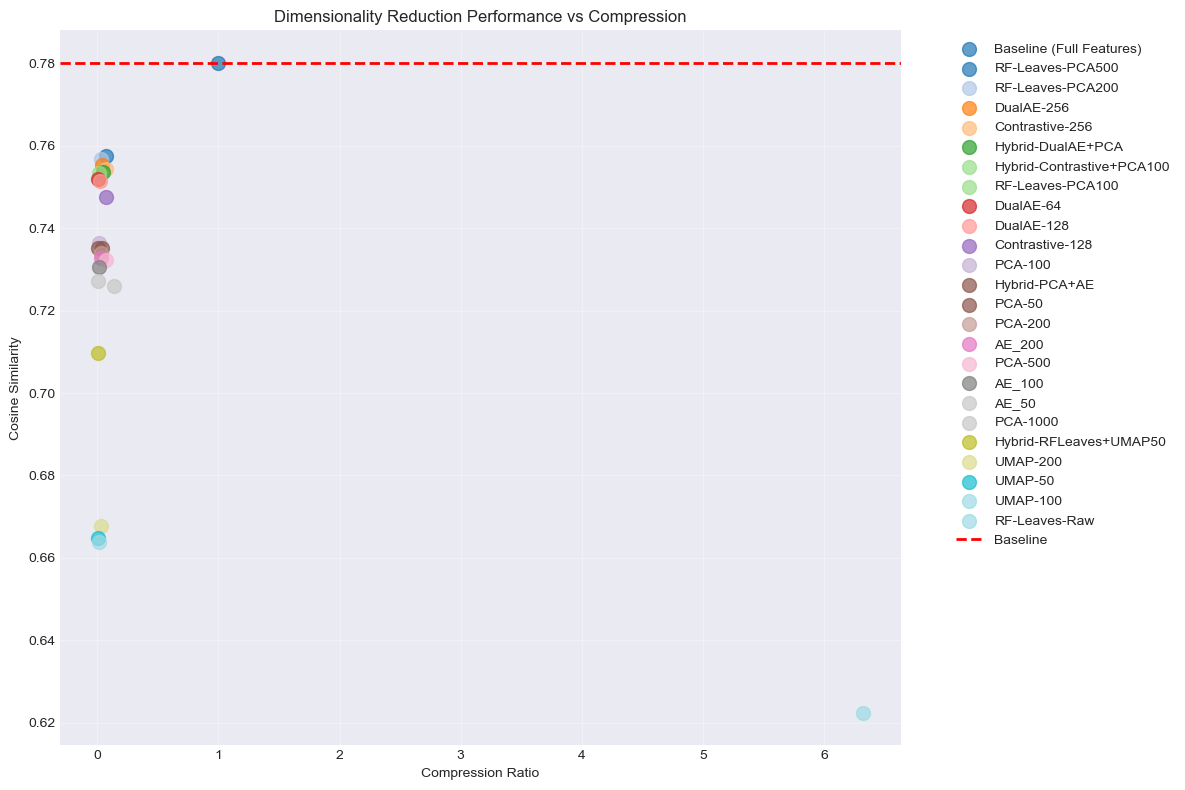

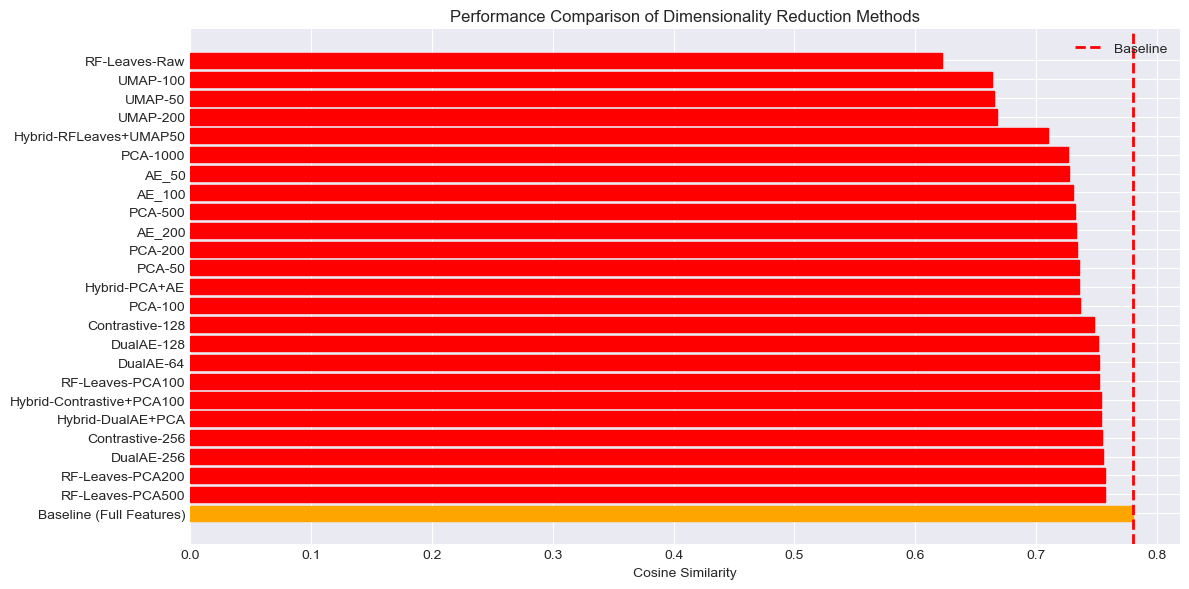

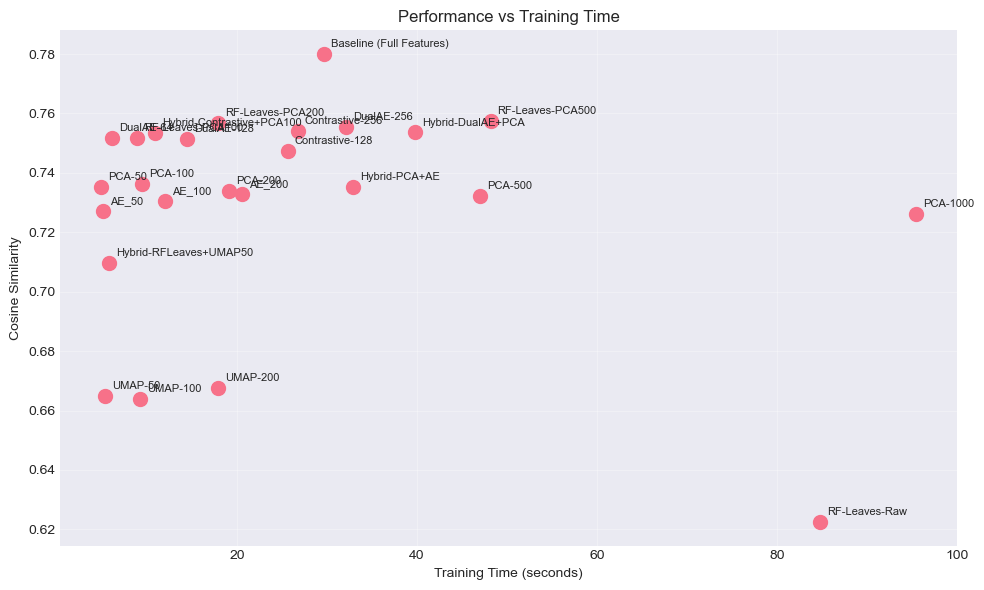


KEY FINDINGS:
1. Best performing method: Baseline (Full Features)
   - Cosine Similarity: 0.7801
   - Improvement over baseline: 0.0000
   - Compression ratio: 100.00%

Baseline (Full Features) Compression Summary:
  Original dimensions: 7,135
  Reduced dimensions: 7,135
  Compression ratio: 1.0000 (0.0% reduction)
  Data size reduction: 1.0x smaller

2. Most efficient method (>95% performance):
   - Method: Contrastive-128
   - Features: 512 (7.18%)
   - Cosine Similarity: 0.7475

3. All reduced features saved to: ../reduced_features
   - Pickle files contain models and metadata
   - JSONL files contain train/val/test splits for each method

Dimensionality reduction analysis complete!


In [11]:
print("\nFINAL RESULTS SUMMARY")
print("=" * 80)

# Convert results to DataFrame
results_df = pd.DataFrame(results)
results_df['compression_ratio'] = results_df['n_features'] / X_train.shape[1]
results_df['improvement'] = results_df['cosine_similarity'] - baseline_result['cosine_similarity']
results_df = results_df.sort_values('cosine_similarity', ascending=False)

# Display results table
print("\nPerformance Comparison:")
print(results_df[['method', 'n_features', 'compression_ratio', 'cosine_similarity', 
                  'improvement', 'train_time']].to_string(index=False))

# Save complete results
results_summary = {
    'results_df': results_df,
    'baseline_performance': baseline_result['cosine_similarity'],
    'best_method': results_df.iloc[0]['method'],
    'best_performance': results_df.iloc[0]['cosine_similarity'],
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S')
}

save_path = os.path.join(MASTER_CONFIG['paths']['reduced_dir'], 'results_summary.pkl')
with open(save_path, 'wb') as f:
    pickle.dump(results_summary, f)

# Visualization 1: Performance vs Compression
plt.figure(figsize=(12, 8))
colors = plt.cm.tab20(np.linspace(0, 1, len(results_df)))

for idx, (_, row) in enumerate(results_df.iterrows()):
    plt.scatter(row['compression_ratio'], row['cosine_similarity'], 
               s=100, color=colors[idx], label=row['method'], alpha=0.7)

plt.axhline(y=baseline_result['cosine_similarity'], color='red', 
           linestyle='--', label='Baseline', linewidth=2)
plt.xlabel('Compression Ratio')
plt.ylabel('Cosine Similarity')
plt.title('Dimensionality Reduction Performance vs Compression')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Visualization 2: Method Comparison Bar Chart
fig, ax = plt.subplots(figsize=(12, 6))
methods = results_df['method'].values
cosine_sims = results_df['cosine_similarity'].values
y_pos = np.arange(len(methods))

bars = ax.barh(y_pos, cosine_sims)
ax.axvline(x=baseline_result['cosine_similarity'], color='red', 
          linestyle='--', label='Baseline', linewidth=2)

# Color bars based on performance
for i, (bar, sim) in enumerate(zip(bars, cosine_sims)):
    if sim > baseline_result['cosine_similarity']:
        bar.set_color('green')
    elif sim > baseline_result['cosine_similarity'] - 0.02:
        bar.set_color('orange')
    else:
        bar.set_color('red')

ax.set_yticks(y_pos)
ax.set_yticklabels(methods)
ax.set_xlabel('Cosine Similarity')
ax.set_title('Performance Comparison of Dimensionality Reduction Methods')
ax.legend()
plt.tight_layout()
plt.show()

# Visualization 3: Training Time Analysis
plt.figure(figsize=(10, 6))
fast_methods = results_df[results_df['train_time'] < 100]
plt.scatter(fast_methods['train_time'], fast_methods['cosine_similarity'], s=100)

for _, row in fast_methods.iterrows():
    plt.annotate(row['method'], (row['train_time'], row['cosine_similarity']), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.xlabel('Training Time (seconds)')
plt.ylabel('Cosine Similarity')
plt.title('Performance vs Training Time')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Key findings
print("\nKEY FINDINGS:")
print("=" * 50)
print(f"1. Best performing method: {results_df.iloc[0]['method']}")
print(f"   - Cosine Similarity: {results_df.iloc[0]['cosine_similarity']:.4f}")
print(f"   - Improvement over baseline: {results_df.iloc[0]['improvement']:.4f}")
print(f"   - Compression ratio: {results_df.iloc[0]['compression_ratio']:.2%}")
print_compression_summary(ORIGINAL_DIM, results_df.iloc[0]['n_features'], results_df.iloc[0]['method'])

# Best method maintaining >95% performance
threshold = baseline_result['cosine_similarity'] * 0.95
efficient_methods = results_df[results_df['cosine_similarity'] > threshold]
if len(efficient_methods) > 0:
    best_efficient = efficient_methods.iloc[-1]  # Highest compression
    print(f"\n2. Most efficient method (>95% performance):")
    print(f"   - Method: {best_efficient['method']}")
    print(f"   - Features: {best_efficient['n_features']} ({best_efficient['compression_ratio']:.2%})")
    print(f"   - Cosine Similarity: {best_efficient['cosine_similarity']:.4f}")

print(f"\n3. All reduced features saved to: {MASTER_CONFIG['paths']['reduced_dir']}")
print("   - Pickle files contain models and metadata")
print("   - JSONL files contain train/val/test splits for each method")
print("\nDimensionality reduction analysis complete!")